In [21]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/test'

In [5]:
# Import the ResNet library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
import tensorflow
resnet152V2 =tensorflow.keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + /
                                                       [3], weights='imagenet', include_top=False)

234553344/234545216 [==============================] - 2s 0us/step


In [7]:
# don't train existing weights
for layer in resnet152V2.layers:
    layer.trainable = False

In [10]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train/*')

In [11]:
folders

['/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train/fresh cotton plant',
 '/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train/fresh cotton leaf',
 '/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train/diseased cotton plant',
 '/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train/diseased cotton leaf']

In [12]:
# our layers - you can add more if you want
x = Flatten()(resnet152V2.output)

In [13]:
# Output layer
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [15]:
# model cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [19]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Cotton Classification/Data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [22]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
61/61 [==============================] - 206s 3s/step - loss: 0.6568 - accuracy: 0.9103 - val_loss: 1.2121 - val_accuracy: 0.9444
Epoch 2/20
61/61 [==============================] - 39s 634ms/step - loss: 0.5421 - accuracy: 0.9334 - val_loss: 0.5243 - val_accuracy: 0.9444
Epoch 3/20
61/61 [==============================] - 38s 630ms/step - loss: 0.4124 - accuracy: 0.9472 - val_loss: 0.1012 - val_accuracy: 0.9444
Epoch 4/20
61/61 [==============================] - 38s 624ms/step - loss: 0.3909 - accuracy: 0.9621 - val_loss: 0.3698 - val_accuracy: 0.9444
Epoch 5/20
61/61 [==============================] - 38s 621ms/step - loss: 0.5035 - accuracy: 0.9482 - val_loss: 0.6587 - val_accuracy: 0.8889
Epoch 6/20
61/61 [==============================] - 38s 626ms/step - loss: 0.5022 - accuracy: 0.9559 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 7/20
61/61 [==============================] - 38s 622ms/step - loss: 0.2920 - accuracy: 0.9698 - val_loss: 0.1248 - val_accuracy: 0.9444
E

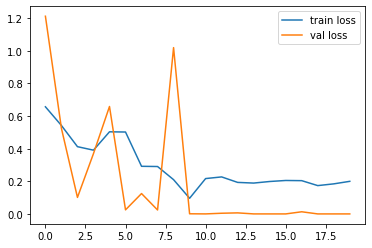

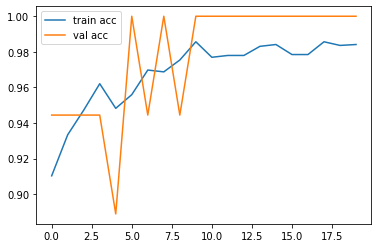

<Figure size 432x288 with 0 Axes>

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
from tensorflow.keras.models import load_model

model.save('model_resnet152V2.h5')

In [25]:
y_pred = model.predict(test_set)

In [ ]:
/content/model_resnet152V2.h5